In [ ]:
from google.colab import drive

# This will prompt you to authenticate and grant access to your Drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [ ]:
# Example placeholder for dataset
df = pd.read_csv("/content/drive/MyDrive/FX/insample.csv")

Model on entire dataset and by Bond

In [ ]:
# Save unique bond values before encoding
unique_bonds = df['Bond'].unique()

# Identify the omitted bond category after get_dummies
# This is the category without a dummy column
omitted_bond = 'US Treasury 10Y'  # Assume the first unique value is omitted (you can validate this)

# Create new column for absolute difference
df['AbsPriceDiff'] = abs(df['QuotedPrice'] - df['MidPrice'])

# Drop QuotedPrice and MidPrice columns
df = df.drop(columns=['QuotedPrice', 'MidPrice', 'Time', 'nextMidPrice'])

# Encode categorical columns
df = pd.get_dummies(df, columns=['Side', 'Counterparty', 'Bond'], drop_first=True)

In [ ]:
# Encode target column
df['Traded'] = df['Traded'].map({'MISSED': 0, 'DONE': 1})

# Feature matrix and target vector
X = df.drop(columns=['Traded'])
y = df['Traded']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM (probability)': SVC(probability=True),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Function to evaluate models
def evaluate_models(X_train, X_test, y_train, y_test, models):
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred_prob = model.predict_proba(X_test)
        y_pred = model.predict(X_test)
        logloss = log_loss(y_test, y_pred_prob)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = {'Log Loss': logloss, 'Accuracy': accuracy}
    return results

# Evaluate overall dataset
overall_results = evaluate_models(X_train, X_test, y_train, y_test, models)

# Print results for overall dataset
print("Overall Results:")
for model_name, metrics in overall_results.items():
    print(f"{model_name}: Log Loss = {metrics['Log Loss']:.4f}, Accuracy = {metrics['Accuracy']:.4f}")

# Subset by Bond and evaluate
best_models_by_bond = {}

for bond in unique_bonds:
    if bond == omitted_bond:
        # Handle the omitted category: select rows where all bond dummy columns are 0
        subset = df[(df[[f'Bond_{b}' for b in unique_bonds if f'Bond_{b}' in df.columns]].sum(axis=1) == 0)]
    else:
        # Use the dummy column for subsetting
        subset = df[df[f'Bond_{bond}'] == 1]

    # Drop all bond dummy columns for the subset
    subset = subset.drop(columns=[f'Bond_{b}' for b in unique_bonds if f'Bond_{b}' in subset.columns])
    X_bond = subset.drop(columns=['Traded'])
    y_bond = subset['Traded']

    X_train_bond, X_test_bond, y_train_bond, y_test_bond = train_test_split(X_bond, y_bond, test_size=0.2, random_state=42)

    bond_results = evaluate_models(X_train_bond, X_test_bond, y_train_bond, y_test_bond, models)
    best_model = min(bond_results, key=lambda model: bond_results[model]['Log Loss'])  # Model with lowest log loss

    best_models_by_bond[bond] = {
        'Best Model': best_model,
        'Log Loss': bond_results[best_model]['Log Loss'],
        'Accuracy': bond_results[best_model]['Accuracy']
    }

# Print best models for each bond
print("\nBest Models by Bond:")
for bond, result in best_models_by_bond.items():
    print(f"Bond: {bond}, Best Model: {result['Best Model']}, Log Loss: {result['Log Loss']:.4f}, Accuracy: {result['Accuracy']:.4f}")

Overall Results:
Logistic Regression: Log Loss = 0.5921, Accuracy = 0.6650
Random Forest: Log Loss = 0.6558, Accuracy = 0.7550
Gradient Boosting: Log Loss = 0.4798, Accuracy = 0.7450
SVM (probability): Log Loss = 0.6652, Accuracy = 0.6750
XGBoost: Log Loss = 0.5824, Accuracy = 0.7900

Best Models by Bond:
Bond: US Treasury 5Y, Best Model: Random Forest, Log Loss: 0.4084, Accuracy: 0.8372
Bond: US Treasury 3Y, Best Model: Logistic Regression, Log Loss: 0.6294, Accuracy: 0.6429
Bond: US Treasury 10Y, Best Model: Random Forest, Log Loss: 0.4725, Accuracy: 0.7250
Bond: US Treasury 30Y, Best Model: Random Forest, Log Loss: 0.3805, Accuracy: 0.7000
Bond: US Treasury 2Y, Best Model: Logistic Regression, Log Loss: 0.5022, Accuracy: 0.7778


Look at Bid and Ask case separately

In [ ]:
# Example placeholder for dataset
df = pd.read_csv("/content/drive/MyDrive/FX/insample.csv")

In [ ]:
# Create new column for absolute difference
df['AbsPriceDiff'] = abs(df['QuotedPrice'] - df['MidPrice'])

# Drop QuotedPrice and MidPrice columns
df = df.drop(columns=['QuotedPrice', 'MidPrice', 'Time', 'nextMidPrice'])

# Encode categorical columns
df = pd.get_dummies(df, columns=['Counterparty', 'Bond'], drop_first=True)

# Encode target column
df['Traded'] = df['Traded'].map({'MISSED': 0, 'DONE': 1})

# Prepare subsets for ASK and BID
sides = df['Side'].unique()  # Get unique sides (ASK, BID)
best_models_by_side = {}

for side in sides:
    subset = df[df['Side'] == side]  # Subset by Side (ASK or BID)
    subset = subset.drop(columns=['Side'])  # Drop the Side column for modeling

    # Feature matrix and target vector
    X = subset.drop(columns=['Traded'])
    y = subset['Traded']

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'SVM (probability)': SVC(probability=True),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    }

    # Evaluate models
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred_prob = model.predict_proba(X_test)
        y_pred = model.predict(X_test)
        logloss = log_loss(y_test, y_pred_prob)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = {'Log Loss': logloss, 'Accuracy': accuracy}

    # Find the best model for this side
    best_model = min(results, key=lambda model: results[model]['Log Loss'])  # Model with lowest log loss

    best_models_by_side[side] = {
        'Best Model': best_model,
        'Log Loss': results[best_model]['Log Loss'],
        'Accuracy': results[best_model]['Accuracy']
    }

# Print best models for each side
print("\nBest Models by Side:")
for side, result in best_models_by_side.items():
    print(f"Side: {side}, Best Model: {result['Best Model']}, Log Loss: {result['Log Loss']:.4f}, Accuracy: {result['Accuracy']:.4f}")


Best Models by Side:
Side: ASK, Best Model: Random Forest, Log Loss: 0.5286, Accuracy: 0.7426
Side: BID, Best Model: Gradient Boosting, Log Loss: 0.3875, Accuracy: 0.8000


In [ ]:
# Example placeholder for dataset
df = pd.read_csv("/content/drive/MyDrive/FX/insample.csv")

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best Parameters for Lowest Log Loss:
{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Lowest Log Loss on Validation Set: 0.4166
Accuracy of Best Log Loss Model on Test Set: 0.7750


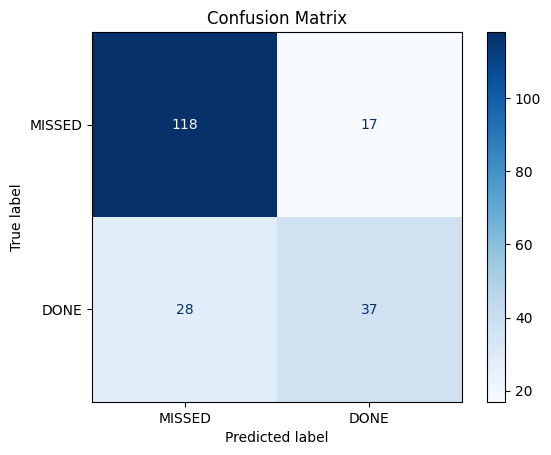

Fitting 3 folds for each of 729 candidates, totalling 2187 fits

Best Parameters for Highest Accuracy:
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 150, 'subsample': 1.0}
Highest Accuracy on Validation Set: 0.8125
Log Loss of Best Accuracy Model on Test Set: 0.4554


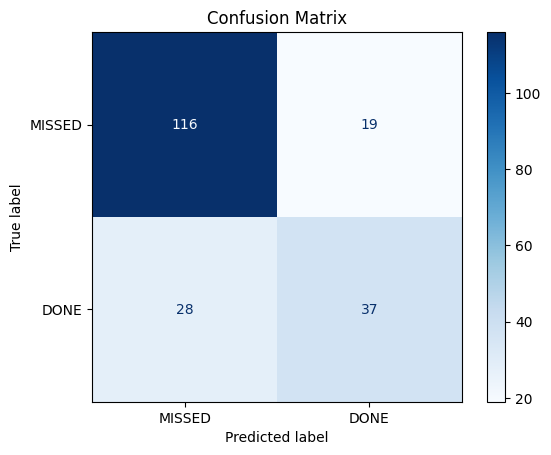

In [ ]:
# Create new column for absolute difference
df['AbsPriceDiff'] = abs(df['QuotedPrice'] - df['MidPrice'])

# Drop QuotedPrice and MidPrice columns
df = df.drop(columns=['QuotedPrice', 'MidPrice', 'Time', 'nextMidPrice'])

# Encode categorical columns
df = pd.get_dummies(df, columns=['Side', 'Counterparty', 'Bond'], drop_first=True)

# Encode target column
df['Traded'] = df['Traded'].map({'MISSED': 0, 'DONE': 1})

# Feature matrix and target vector
X = df.drop(columns=['Traded'])
y = df['Traded']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Perform grid search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_log_loss',  # Use negative log loss for grid search
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1
)

# Fit the grid search model
grid_search.fit(X_train, y_train)

# Best parameters for lowest log loss
best_params_log_loss = grid_search.best_params_
lowest_log_loss = -grid_search.best_score_

# Evaluate the best model on test data for accuracy
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)
y_pred_prob = best_xgb.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)
X_train_prob = best_xgb.predict_proba(X_train)

# Output the results
print("Best Parameters for Lowest Log Loss:")
print(best_params_log_loss)
print(f"Lowest Log Loss on Validation Set: {lowest_log_loss:.4f}")
print(f"Accuracy of Best Log Loss Model on Test Set: {accuracy:.4f}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["MISSED", "DONE"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Grid search for highest accuracy
grid_search_acc = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',  # Use accuracy for grid search
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit the grid search model for accuracy
grid_search_acc.fit(X_train, y_train)

# Best parameters for highest accuracy
best_params_accuracy = grid_search_acc.best_params_
highest_accuracy = grid_search_acc.best_score_

# Evaluate the best model on test data for log loss
best_xgb_acc = grid_search_acc.best_estimator_
y_pred_prob_acc = best_xgb_acc.predict_proba(X_test)
log_loss_acc_model = log_loss(y_test, y_pred_prob_acc)
y_pred = best_xgb_acc.predict(X_test)

# Output the results
print("\nBest Parameters for Highest Accuracy:")
print(best_params_accuracy)
print(f"Highest Accuracy on Validation Set: {highest_accuracy:.4f}")
print(f"Log Loss of Best Accuracy Model on Test Set: {log_loss_acc_model:.4f}")
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["MISSED", "DONE"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 150, 'subsample': 1.0}

{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}

In [ ]:
results = X_test.copy()
results['True_Label'] = y_test.values
results['Predicted_Label'] = y_pred

# Filter the False Negatives (True Label = 1, Predicted Label = 0)
false_negatives = results[(results['True_Label'] == 1) & (results['Predicted_Label'] == 0)]

# Drop the 'True_Label' and 'Predicted_Label' columns to keep only the features
filtered_features = false_negatives.drop(columns=['True_Label', 'Predicted_Label'])


# Describe numeric columns (including binary ones)
numeric_summary = filtered_features.describe()

# Summarize binary columns
binary_summary = filtered_features.select_dtypes(include=['int', 'bool']).apply(
    lambda col: {
        '0s': (col == 0).sum(),
        '1s': (col == 1).sum(),
        'Proportion of 1s': col.mean()
    }
).apply(pd.Series)

# Combine summaries for numeric and binary columns
summary = pd.concat([numeric_summary.T, binary_summary], axis=1)

# Rename columns for clarity
summary.columns = ['Count', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max', '0s', '1s', 'Proportion of 1s']

# Display the combined summary
summary

,Count,Mean,Std,Min,25%,50%,75%,Max,0s,1s,Proportion of 1s
Notional,28.0,3.316071e+06,3.611839e+06,100000.000,437500.00000,2500000.000,5.000000e+06,1.000000e+07,0.0,0.0,3.316071e+06
Competitors,28.0,3.321429e+00,1.944671e+00,1.000,2.00000,3.000,4.000000e+00,7.000000e+00,0.0,6.0,3.321429e+00
AbsPriceDiff,28.0,1.138214e-01,5.866039e-02,0.017,0.07225,0.105,1.432500e-01,3.060000e-01,NaN,NaN,NaN
Side_BID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,5.000000e-01
Counterparty_HF-Fortress,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,6.0,2.142857e-01
Counterparty_RelativeValueStrategies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,4.0,1.428571e-01
Counterparty_SleepyManager,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,5.0,1.785714e-01
Counterparty_SniperFund,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,5.0,1.785714e-01
Counterparty_TankerAssetManagement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,1.0,3.571429e-02
Bond_US Treasury 2Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,2.0,7.142857e-02


In [ ]:
compare = summary['Proportion of 1s']

In [ ]:
compare = pd.DataFrame(compare)

In [ ]:
newdf = df.drop(columns='Traded')

In [ ]:
# Describe numeric columns (including binary ones)
numeric_summary = newdf.describe()

# Summarize binary columns
binary_summary = newdf.select_dtypes(include=['int', 'bool']).apply(
    lambda col: {
        '0s': (col == 0).sum(),
        '1s': (col == 1).sum(),
        'Proportion of 1s': col.mean()
    }
).apply(pd.Series)

# Combine summaries for numeric and binary columns
summary = pd.concat([numeric_summary.T, binary_summary], axis=1)

# Rename columns for clarity
summary.columns = ['Count', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max', '0s', '1s', 'Proportion of 1s']

# Display the combined summary
summary

,Count,Mean,Std,Min,25%,50%,75%,Max,0s,1s,Proportion of 1s
Notional,1000.0,2.818100e+06,3.371883e+06,100000.0,250000.000,1000000.000,5000000.000,1.000000e+07,0.0,0.0,2818100.000
Competitors,1000.0,4.002000e+00,2.006994e+00,1.0,2.000,4.000,6.000,7.000000e+00,0.0,148.0,4.002
AbsPriceDiff,1000.0,1.244870e-01,9.214301e-02,0.0,0.057,0.107,0.167,5.130000e-01,NaN,NaN,NaN
Side_BID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,502.0,498.0,0.498
Counterparty_HF-Fortress,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,842.0,158.0,0.158
Counterparty_RelativeValueStrategies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,826.0,174.0,0.174
Counterparty_SleepyManager,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,825.0,175.0,0.175
Counterparty_SniperFund,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,832.0,168.0,0.168
Counterparty_TankerAssetManagement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,833.0,167.0,0.167
Bond_US Treasury 2Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,822.0,178.0,0.178


In [ ]:
compare['Entire df Proportion of 1s'] = summary['Proportion of 1s']


,Proportion of 1s,Entire df Proportion of 1s
Notional,3.316071e+06,2818100.000
Competitors,3.321429e+00,4.002
AbsPriceDiff,NaN,NaN
Side_BID,5.000000e-01,0.498
Counterparty_HF-Fortress,2.142857e-01,0.158
Counterparty_RelativeValueStrategies,1.428571e-01,0.174
Counterparty_SleepyManager,1.785714e-01,0.175
Counterparty_SniperFund,1.785714e-01,0.168
Counterparty_TankerAssetManagement,3.571429e-02,0.167
Bond_US Treasury 2Y,7.142857e-02,0.178


In [ ]:
# Convert all values in the DataFrame to a simpler decimal format
compare = compare.applymap(lambda x: '{:.6f}'.format(x) if isinstance(x, float) else x)
compare

,Proportion of 1s,Entire df Proportion of 1s
Notional,3316071.428571,2818100.000000
Competitors,3.321429,4.002000
AbsPriceDiff,nan,nan
Side_BID,0.500000,0.498000
Counterparty_HF-Fortress,0.214286,0.158000
Counterparty_RelativeValueStrategies,0.142857,0.174000
Counterparty_SleepyManager,0.178571,0.175000
Counterparty_SniperFund,0.178571,0.168000
Counterparty_TankerAssetManagement,0.035714,0.167000
Bond_US Treasury 2Y,0.071429,0.178000


In [ ]:
X_train_prob

array([[0.9343833 , 0.06561673],
       [0.9108485 , 0.08915148],
       [0.5320051 , 0.4679949 ],
       ...,
       [0.9135983 , 0.08640172],
       [0.899387  , 0.10061297],
       [0.47156322, 0.5284368 ]], dtype=float32)

In [ ]:
df00 = pd.DataFrame(y_train)
df00['Prob'] = X_train_prob[:, 1]
df001 = df00[df00['Traded'] == 0]

In [ ]:
average = sum(df001['Prob']) / len(df001['Prob'])
average

0.1599634949862318

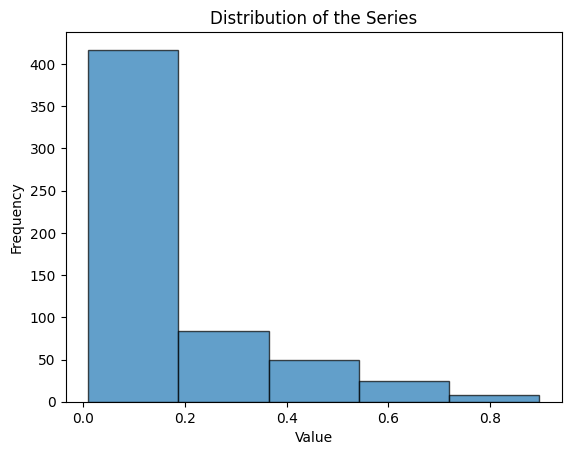

In [ ]:
# Plotting the histogram
plt.hist(df001['Prob'], bins=5, edgecolor='black', alpha=0.7)
plt.title("Distribution of the Series")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Preprocess OS data
def preprocess_os_data(df, training_columns):
    # Create new column for absolute difference
    df['AbsPriceDiff'] = abs(df['QuotedPrice'] - df['MidPrice'])

    # Drop irrelevant columns
    df = df.drop(columns=['QuotedPrice', 'MidPrice', 'Time'])

    # Encode categorical variables
    df = pd.get_dummies(df, columns=['Side', 'Counterparty', 'Bond'], drop_first=True)

    # Ensure the OS data has the same columns as training data
    for col in training_columns:
        if col not in df.columns:
            df[col] = 0  # Add missing columns with default value 0

    # Ensure column order matches training data
    df = df[training_columns]

    return df

# Assuming OS data is loaded as `os_df`
os_df = pd.read_csv('/content/drive/MyDrive/FX/os.csv')  # Replace with the actual path to your OS data
os_df = os_df.dropna()

# Preprocess OS data
training_columns = X_train.columns  # Columns used during training
os_X = preprocess_os_data(os_df, training_columns)

# Reinitialize XGBoost with best_params_accuracy
xgb_best = XGBClassifier(**best_params_accuracy, use_label_encoder=False, eval_metric='logloss')

# Fit the model on the entire training data
xgb_best.fit(X, y)

# Predict probabilities and class labels on OS data
os_pred_prob = xgb_best.predict_proba(os_X)  # Predict probabilities
os_pred_class = xgb_best.predict(os_X)       # Predict class labels

# Add predictions to OS data
os_df['Predicted_Probability_DONE'] = os_pred_prob[:, 1]  # Probability of TRADED = DONE
os_df['Predicted_Trade_Class'] = os_pred_class  # Predicted class (0 = MISSED, 1 = DONE)

# Output the results
print(os_df[['Predicted_Probability_DONE', 'Predicted_Trade_Class']])


    Predicted_Probability_DONE  Predicted_Trade_Class
0                     0.037733                      0
1                     0.143941                      0
2                     0.053642                      0
3                     0.480505                      0
4                     0.583806                      1
..                         ...                    ...
95                    0.652227                      1
96                    0.167711                      0
97                    0.050202                      0
98                    0.113313                      0
99                    0.081824                      0

[100 rows x 2 columns]


In [ ]:
value_counts = os_df['Predicted_Trade_Class'].value_counts()
value_counts

,count
Predicted_Trade_Class,
0,89
1,11


In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split

# Preprocess OS data
def preprocess_os_data(df, training_columns):
    # Create new column for absolute difference
    df['AbsPriceDiff'] = abs(df['QuotedPrice'] - df['MidPrice'])

    # Drop irrelevant columns
    df = df.drop(columns=['QuotedPrice', 'MidPrice', 'Time'], errors='ignore')

    # Encode categorical variables
    df = pd.get_dummies(df, columns=['Side', 'Counterparty', 'Bond'], drop_first=True)

    # Ensure the OS data has the same columns as training data
    for col in training_columns:
        if col not in df.columns:
            df[col] = 0  # Add missing columns with default value 0

    # Ensure column order matches training data
    df = df[training_columns]

    return df

# Simulated Training Data (replace with your actual data)
df = pd.read_csv('/content/drive/MyDrive/FX/insample.csv')  # Load your training data
# Preprocessing and splitting
df['AbsPriceDiff'] = abs(df['QuotedPrice'] - df['MidPrice'])
df = pd.get_dummies(df, columns=['Side', 'Counterparty', 'Bond'], drop_first=True)
df['Traded'] = df['Traded'].map({'MISSED': 0, 'DONE': 1})  # Encode target
X = df.drop(columns=['Traded'])
y = df['Traded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the base XGBoost model
best_params_accuracy = {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 150, 'subsample': 1.0}
xgb_best = XGBClassifier(**best_params_accuracy, use_label_encoder=False, eval_metric='logloss')

# Train the base model
xgb_best.fit(X_train, y_train)

# Calibrate the model
calibrated_model = CalibratedClassifierCV(xgb_best, method='isotonic', cv='prefit')
calibrated_model.fit(X_train, y_train)  # Fit calibration using training data

# Load OS Data
os_df = pd.read_csv('/content/drive/MyDrive/FX/os.csv')  # Replace with the path to your OS data
os_df = os_df.dropna()

# Preprocess OS data
os_X = preprocess_os_data(os_df, training_columns=X.columns)

# Predict probabilities and class labels on OS data
os_pred_prob_calibrated = calibrated_model.predict_proba(os_X)  # Predict probabilities
os_pred_class_calibrated = calibrated_model.predict(os_X)       # Predict class labels

# Add predictions to OS data
os_df['Calibrated_Probability_DONE'] = os_pred_prob_calibrated[:, 1]  # Probability of DONE
os_df['Calibrated_Predicted_Class'] = os_pred_class_calibrated        # Class (0 = MISSED, 1 = DONE)

print(os_df[['Calibrated_Probability_DONE', 'Calibrated_Predicted_Class']].head())

   Calibrated_Probability_DONE  Calibrated_Predicted_Class
0                     0.021739                           0
1                     0.301075                           0
2                     0.000000                           0
3                     0.301075                           0
4                     0.932203                           1


In [ ]:
value_counts = os_df['Calibrated_Predicted_Class'].value_counts()
value_counts

,count
Calibrated_Predicted_Class,
0,82
1,18


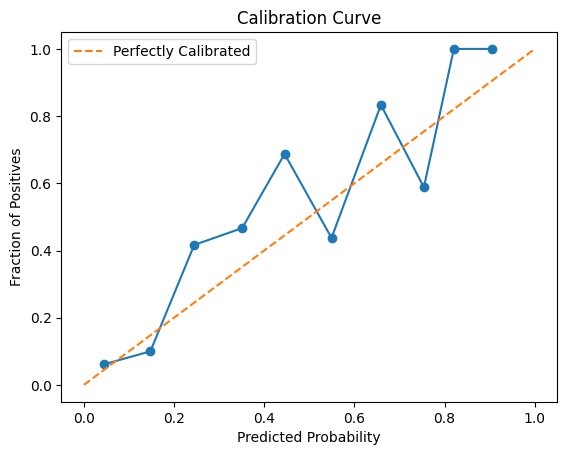

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Compute calibration curve
prob_true, prob_pred = calibration_curve(y_test, xgb_best.predict_proba(X_test)[:, 1], n_bins=10)

# Plot the curve
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

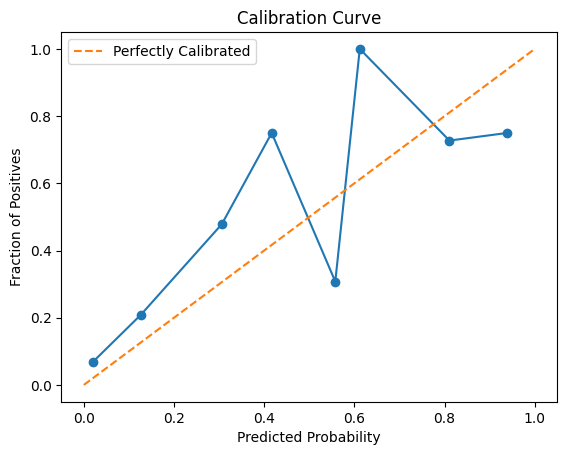

In [ ]:
# Compute calibration curve
prob_true, prob_pred = calibration_curve(y_test, calibrated_model.predict_proba(X_test)[:, 1], n_bins=10)

# Plot the curve
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/FX/insample.csv")

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best Parameters for Lowest Log Loss:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 50, 'subsample': 0.6}
Lowest Log Loss on Validation Set: 0.4136
Accuracy of Best Log Loss Model on Test Set: 0.7800


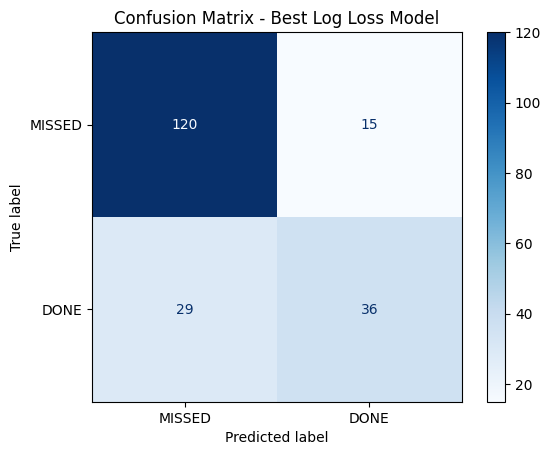

Fitting 3 folds for each of 729 candidates, totalling 2187 fits

Best Parameters for Highest Accuracy:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Highest Accuracy on Validation Set: 0.8075
Log Loss of Best Accuracy Model on Test Set: 0.4758


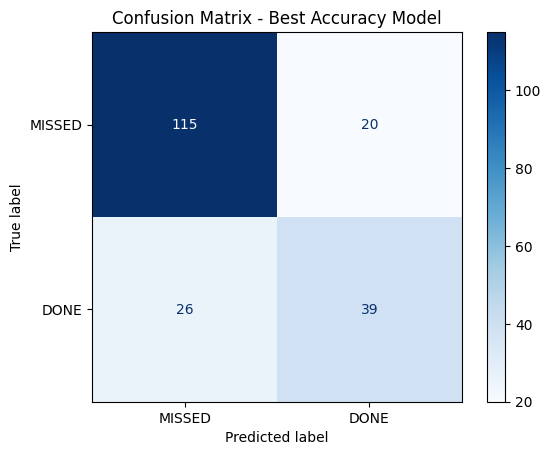

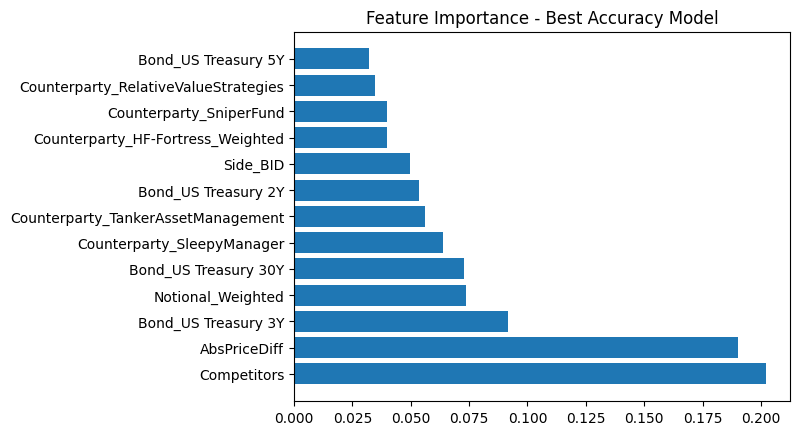

In [ ]:
# Create a new column for absolute price difference
df['AbsPriceDiff'] = abs(df['QuotedPrice'] - df['MidPrice'])

# Drop unnecessary columns
df = df.drop(columns=['QuotedPrice', 'MidPrice', 'Time', 'nextMidPrice'])

# Encode categorical columns
df = pd.get_dummies(df, columns=['Side', 'Counterparty', 'Bond'], drop_first=True)

# Encode target column
df['Traded'] = df['Traded'].map({'MISSED': 0, 'DONE': 1})

# Weighted Features with Original Columns Dropped
if 'Competitor_Number' in df.columns:
    df['Competitor_Number_Weighted'] = 1 / (df['Competitor_Number'] + 1)
    df = df.drop(columns=['Competitor_Number'])

if 'Counterparty_HF-Fortress' in df.columns:
    df['Counterparty_HF-Fortress_Weighted'] = df['Counterparty_HF-Fortress'] * 2
    df = df.drop(columns=['Counterparty_HF-Fortress'])

if 'Notional' in df.columns:
    df['Notional_Weighted'] = df['Notional'] ** 1.5
    df = df.drop(columns=['Notional'])

# Feature matrix and target vector
X = df.drop(columns=['Traded'])
y = df['Traded']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Perform grid search for lowest log loss
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_log_loss',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_params_log_loss = grid_search.best_params_
lowest_log_loss = -grid_search.best_score_

best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters for Lowest Log Loss:")
print(best_params_log_loss)
print(f"Lowest Log Loss on Validation Set: {lowest_log_loss:.4f}")
print(f"Accuracy of Best Log Loss Model on Test Set: {accuracy:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["MISSED", "DONE"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Best Log Loss Model")
plt.show()

# Perform grid search for highest accuracy
grid_search_acc = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search_acc.fit(X_train, y_train)

best_params_accuracy = grid_search_acc.best_params_
highest_accuracy = grid_search_acc.best_score_

best_xgb_acc = grid_search_acc.best_estimator_
y_pred_acc = best_xgb_acc.predict(X_test)
log_loss_acc_model = log_loss(y_test, best_xgb_acc.predict_proba(X_test))

print("\nBest Parameters for Highest Accuracy:")
print(best_params_accuracy)
print(f"Highest Accuracy on Validation Set: {highest_accuracy:.4f}")
print(f"Log Loss of Best Accuracy Model on Test Set: {log_loss_acc_model:.4f}")

conf_matrix_acc = confusion_matrix(y_test, y_pred_acc)
disp_acc = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_acc, display_labels=["MISSED", "DONE"])
disp_acc.plot(cmap="Blues")
plt.title("Confusion Matrix - Best Accuracy Model")
plt.show()

feature_importance_acc = best_xgb_acc.feature_importances_
sorted_idx_acc = feature_importance_acc.argsort()[::-1]
plt.barh(X_train.columns[sorted_idx_acc], feature_importance_acc[sorted_idx_acc])
plt.title("Feature Importance - Best Accuracy Model")
plt.show()


In [ ]:
df.columns

Index(['Notional', 'Competitors', 'Traded', 'AbsPriceDiff', 'Side_BID',
       'Counterparty_HF-Fortress', 'Counterparty_RelativeValueStrategies',
       'Counterparty_SleepyManager', 'Counterparty_SniperFund',
       'Counterparty_TankerAssetManagement', 'Bond_US Treasury 2Y',
       'Bond_US Treasury 30Y', 'Bond_US Treasury 3Y', 'Bond_US Treasury 5Y',
       'Counterparty_HF-Fortress_Weighted', 'Notional_Weighted'],
      dtype='object')